# CATE Estimation with Causal Effect Variational Autoencoder (CEVAE)

In this notebook, we demonstrate how to estimate **Conditional Average Treatment Effects
(CATE)** using a **Causal Effect Variational Autoencoder (CEVAE)** implemented in
[NumPyro](https://num.pyro.ai/). This approach is particularly useful when we suspect
the presence of **unobserved confounders** that affect both treatment assignment and
outcomes.

## Motivation: Why CEVAE?

In observational studies, estimating causal effects is challenging because:

1. **Confounding**: Variables that affect both treatment and outcome can bias naive
   estimates
2. **Unobserved confounders**: Often, we cannot measure all confounding variables
3. **Selection bias**: Treatment assignment is typically not random

The CEVAE framework, introduced by
[Louizos et al. (2017)](https://arxiv.org/abs/1705.08821), addresses these challenges
by:

- Modeling a **latent confounder** $z$ that captures unobserved confounding
- Using **variational inference** to infer the posterior distribution of $z$
- Leveraging **neural networks** for flexible function approximation

This notebook follows the methodology from the
[ChiRho CEVAE tutorial](https://basisresearch.github.io/chirho/cevae.html), adapted
for pure NumPyro.

## Key Concepts

### Potential Outcomes Framework

The **Conditional Average Treatment Effect (CATE)** for an individual with
characteristics captured by latent variable $z$ is defined as:

$$\text{CATE}(z) = \mathbb{E}[Y(1) - Y(0) \mid z] = P(Y=1 \mid \text{do}(T=1), z) -
P(Y=1 \mid \text{do}(T=0), z)$$

where:
- $Y(1)$ is the **potential outcome** under treatment ($T=1$)
- $Y(0)$ is the **potential outcome** under control ($T=0$)
- $\text{do}(T=t)$ denotes an **intervention** setting treatment to value $t$

The fundamental problem of causal inference is that we only observe one potential
outcome per individual—the one corresponding to their actual treatment.

### The CEVAE Graphical Model

The CEVAE assumes the following generative process:

```
       z (latent confounder)
      /|\
     / | \
    v  v  v
    x  t  y
       |
       v
       y
```

Where:
- $z$: Latent confounder (unobserved)
- $x$: Observed covariates (proxy for $z$)
- $t$: Treatment assignment
- $y$: Outcome

The key insight is that while $z$ is unobserved, we can **infer** it from the observed
variables using variational inference.

## Setup

In [ ]:
from itertools import pairwise

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
from flax import nnx
from jax import random
from jaxtyping import Array, Float, Int
from numpyro.contrib.module import nnx_module
from numpyro.handlers import condition, do, seed, trace
from numpyro.infer import SVI, Predictive, Trace_ELBO

plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

rng_key = random.PRNGKey(seed=42)

## Data Generating Process (DGP)

We simulate data with a **known** data generating process so we can validate our
CATE estimates. This is crucial for understanding whether our method works correctly.

### The True DGP

Our synthetic data follows this generative process:

1. **Latent confounder**: $z \sim \text{Bernoulli}(0.5)$
   - Binary latent variable that we **cannot observe** in practice

2. **Covariates**: $x_i \mid z \sim \text{Normal}(z \cdot \text{z\_gap},
   \sigma_z)$ for $i = 1, \ldots, d$
   - Covariates are **proxies** for the latent confounder
   - Different means and variances depending on $z$

3. **Treatment**: $t \mid z \sim \text{Bernoulli}(0.75z + 0.25(1-z))$
   - Treatment probability depends on $z$ (confounding!)
   - When $z=1$: $P(T=1) = 0.75$
   - When $z=0$: $P(T=1) = 0.25$

4. **Outcome**: $y \mid z, t \sim \text{Bernoulli}(\text{logits} =
   \text{y\_gap} \cdot (z + 2(2t - 1)))$
   - Outcome depends on **both** $z$ and $t$
   - The treatment effect varies with $z$

### True CATE Calculation

From the DGP, we can analytically compute the true CATE:

$$\text{CATE}(z) = \sigma(\text{y\_gap} \cdot (z + 2)) -
\sigma(\text{y\_gap} \cdot (z - 2))$$

where $\sigma$ is the sigmoid function. With `y_gap = 3.0`:
- For $z=0$: $\text{CATE} = \sigma(6) - \sigma(-6) \approx 0.995$
- For $z=1$: $\text{CATE} = \sigma(9) - \sigma(-3) \approx 0.952$

In [ ]:
# Parameters
NUM_TRAIN = 10_000
NUM_TEST = 2_000
FEATURE_DIM = 10
Z_GAP = 1.0
Y_GAP = 3.0


def generate_data(
    num_data: int, feature_dim: int, z_gap: float, y_gap: float
) -> tuple[Array, Array, Array, Array]:
    """Generate synthetic data with latent confounder.

    Parameters
    ----------
    num_data : int
        Number of observations to generate
    feature_dim : int
        Dimension of the covariate vector x
    z_gap : float
        Controls separation between z=0 and z=1 in covariate space
    y_gap : float
        Controls the strength of treatment effect

    Returns
    -------
    x : Array of shape (num_data, feature_dim)
        Observed covariates
    t : Array of shape (num_data,)
        Binary treatment assignment
    y : Array of shape (num_data,)
        Binary outcome
    z : Array of shape (num_data,)
        Latent confounder (for evaluation only)
    """
    with numpyro.plate("num_data", num_data):
        # Latent confounder - THIS IS UNOBSERVED IN PRACTICE
        z = numpyro.sample("z", dist.Bernoulli(0.5))

        # Covariates depend on z (proxies for the confounder)
        with numpyro.plate("feature_dim", feature_dim):
            x = numpyro.sample("x", dist.Normal(z * z_gap, 5 * z + 3 * (1 - z))).T

        # Treatment depends on z (confounding!)
        t = numpyro.sample("t", dist.Bernoulli(0.75 * z + 0.25 * (1 - z)))

        # Outcome depends on BOTH z and t
        y = numpyro.sample("y", dist.Bernoulli(logits=y_gap * (z + 2 * (2 * t - 1))))

        return x, t, y, z

In [ ]:
# Generate training data (z is discarded - we pretend we can't observe it)
rng_key, rng_subkey = random.split(rng_key)
x_train, t_train, y_train, _ = trace(seed(generate_data, rng_subkey))(
    NUM_TRAIN, FEATURE_DIM, Z_GAP, Y_GAP
)

# Generate test data (keep z for evaluation purposes)
rng_key, rng_subkey = random.split(rng_key)
x_test, t_test, y_test, z_test = trace(seed(generate_data, rng_subkey))(
    NUM_TEST, FEATURE_DIM, Z_GAP, Y_GAP
)

# Compute TRUE CATE for evaluation (we know the DGP!)
true_cate_probs = jax.nn.sigmoid(Y_GAP * (z_test + 2)) - jax.nn.sigmoid(
    Y_GAP * (z_test - 2)
)

print(f"True CATE (z=0): {true_cate_probs[z_test == 0].mean():.4f}")
print(f"True CATE (z=1): {true_cate_probs[z_test == 1].mean():.4f}")

True CATE (z=0): 0.9951
True CATE (z=1): 0.9524


## Why Naive Approaches Fail

Before diving into CEVAE, let's understand why simpler approaches fail for CATE
estimation with unobserved confounders.

### Naive Approach 1: Simple Difference in Means

A naive estimate would be:
$$\widehat{\text{ATE}}_{\text{naive}} = \bar{Y}_{T=1} - \bar{Y}_{T=0}$$

This is **biased** because treatment assignment is confounded by $z$. People with
$z=1$ are more likely to receive treatment AND have different baseline outcomes.

In [ ]:
# Naive ATE estimate (biased due to confounding)
naive_ate = y_train[t_train == 1].mean() - y_train[t_train == 0].mean()
true_ate = true_cate_probs.mean()
print(f"Naive ATE estimate: {naive_ate:.4f}")
print(f"True ATE: {true_ate:.4f}")
print(f"Bias: {naive_ate - true_ate:.4f}")

Naive ATE estimate: 0.9873
True ATE: 0.9738
Bias: 0.0135


### Naive Approach 2: Separate `do()` Calls for Counterfactuals

A tempting but **incorrect** approach for computing CATE is:

```python
# DON'T DO THIS!
predictive_t0 = Predictive(do(model, {"t_obs": 0}), ...)
predictive_t1 = Predictive(do(model, {"t_obs": 1}), ...)

y_t0 = predictive_t0(...)["y_obs"]  # Samples new z values!
y_t1 = predictive_t1(...)["y_obs"]  # Samples DIFFERENT z values!

cate = y_t1 - y_t0  # WRONG: comparing different individuals!
```

**Why this fails**: Each `Predictive` call samples **new, independent** values of
$z$. So `y_t0` and `y_t1` correspond to **different individuals**, not the same
individual under different treatments.

For valid CATE estimation, we need to compare potential outcomes for the **same**
individual, which means using the **same** $z$ sample for both interventions.

## Neural Network Components

We use [Flax NNX](https://flax.readthedocs.io/en/latest/nnx/index.html) for defining
neural network modules that integrate with NumPyro via `nnx_module`.

### Architecture Overview

Our CEVAE consists of:

1. **Decoder networks** (generative model):
   - `x_nn`: $z \to (\mu_x, \sigma_x)$ - generates covariates from latent
   - `t_nn`: $z \to \text{logits}_t$ - generates treatment probability
   - `y_nn_t0`, `y_nn_t1`: $z \to \text{logits}_y$ - generates outcome probability

2. **Encoder networks** (inference/guide):
   - Training encoder: $(x, t, y) \to (\mu_z, \sigma_z)$ - infers $z$ from all
     observed data
   - Test encoder: $x \to (\mu_z, \sigma_z)$ - infers $z$ from covariates only

### Critical Design Choice: Separate Outcome Networks

A key insight from debugging this implementation: **use separate linear networks
for each treatment level**.

#### Why Not a Single Network?

Initially, we tried a single network: `y_nn(z, t) -> logits_y`. This **failed**
because:

1. The network learned to rely primarily on $t$ (which strongly predicts $y$)
2. It essentially ignored $z$, collapsing to: $P(Y=1 \mid t) \approx \text{const}$
3. Result: $\text{CATE} \approx 0.73$ regardless of $z$ (wrong!)

#### The Solution: Two Linear Networks

By using **separate** networks that take **only $z$** as input:
- `y_nn_t0(z)`: Learns $P(Y=1 \mid \text{do}(T=0), z)$
- `y_nn_t1(z)`: Learns $P(Y=1 \mid \text{do}(T=1), z)$

Each network **must** use $z$ to produce different outputs—it cannot collapse to a
constant. Using **linear** layers (no hidden layers) works well here because the
true DGP is linear in $z$.

In [ ]:
LATENT_DIM = 1
HIDDEN_DIM = 50
NUM_LAYERS = 2


class FullyConnected(nnx.Module):
    """Base fully connected network with ELU activations."""

    def __init__(
        self, din: int, dout: int, hidden_layers: list[int], *, rngs: nnx.Rngs
    ) -> None:
        self.layers = nnx.List([])
        layer_dims = [din, *hidden_layers, dout]
        for in_dim, out_dim in pairwise(layer_dims):
            self.layers.append(nnx.Linear(in_dim, out_dim, rngs=rngs))

    def __call__(self, x: Array) -> Array:
        for layer in self.layers:
            x = jax.nn.elu(layer(x))
        return x


class DiagNormalNet(FullyConnected):
    """Network outputting mean and scale for a diagonal normal distribution."""

    def __init__(
        self, din: int, dout: int, hidden_layers: list[int], *, rngs: nnx.Rngs
    ):
        super().__init__(din, 2 * dout, hidden_layers, rngs=rngs)

    def __call__(self, x: Array) -> tuple[Array, Array]:
        loc, scale = jnp.split(super().__call__(x), 2, axis=-1)
        return loc, jax.nn.softplus(scale)


class BernoulliNet(FullyConnected):
    """Network outputting logits for a Bernoulli distribution."""

    def __call__(self, x: Array) -> Array:
        return jax.lax.clamp(-10.0, super().__call__(x), 10.0)


class Encoder(nnx.Module):
    """Encoder for amortized variational inference q(z|inputs).

    Maps observed data to the parameters of the approximate posterior
    distribution over the latent confounder z.
    """

    def __init__(
        self,
        input_dim: int,
        latent_dim: int,
        hidden_layers: list[int],
        *,
        rngs: nnx.Rngs,
    ) -> None:
        self.layers = nnx.List([])
        layer_dims = [input_dim, *hidden_layers]
        for in_dim, out_dim in pairwise(layer_dims):
            self.layers.append(nnx.Linear(in_dim, out_dim, rngs=rngs))

        final_dim = hidden_layers[-1] if hidden_layers else input_dim
        self.f_loc = nnx.Linear(final_dim, latent_dim, rngs=rngs)
        self.f_scale = nnx.Linear(final_dim, latent_dim, rngs=rngs)

    def __call__(self, x: Array) -> tuple[Array, Array]:
        for layer in self.layers:
            x = jax.nn.elu(layer(x))
        return self.f_loc(x), jax.nn.softplus(self.f_scale(x)) + 1e-6

In [ ]:
# Initialize all neural network modules
hidden_layers = [HIDDEN_DIM] * NUM_LAYERS

rng_key, *subkeys = random.split(rng_key, 7)

# Decoder networks (generative model)
x_nn_module = DiagNormalNet(
    LATENT_DIM, FEATURE_DIM, hidden_layers, rngs=nnx.Rngs(subkeys[0])
)
t_nn_module = BernoulliNet(LATENT_DIM, 1, hidden_layers, rngs=nnx.Rngs(subkeys[1]))

# CRITICAL: Separate LINEAR outcome networks for t=0 and t=1
# Using linear layers forces them to use z (cannot collapse to constants)
y_nn_t0_module = nnx.Linear(LATENT_DIM, 1, rngs=nnx.Rngs(subkeys[2]))
y_nn_t1_module = nnx.Linear(LATENT_DIM, 1, rngs=nnx.Rngs(subkeys[3]))

# Training encoder: q(z|x,t,y) - uses all observed data
encoder_module = Encoder(
    FEATURE_DIM + 2, LATENT_DIM, hidden_layers, rngs=nnx.Rngs(subkeys[4])
)

# Test-time encoder: q(z|x) - infers z from covariates only
test_encoder_module = Encoder(
    FEATURE_DIM, LATENT_DIM, hidden_layers, rngs=nnx.Rngs(subkeys[5])
)

## Model and Guide Definitions

### The Generative Model

The model defines the joint distribution $p(x, t, y, z)$:

$$p(x, t, y, z) = p(z) \cdot p(x \mid z) \cdot p(t \mid z) \cdot p(y \mid z, t)$$

Key points:
- $z$ is sampled from a standard normal prior (we use continuous $z$ in the model
  even though the true DGP has binary $z$)
- The outcome distribution $p(y \mid z, t)$ uses the appropriate network based on
  treatment value

### The Training Guide

During training, we use a guide (variational distribution) that conditions on
**all observed data**: $q(z \mid x, t, y)$.

This is the standard CEVAE approach—using all available information to get the
best possible inference of $z$.

### The Test-Time Guide

At test time, we need to estimate CATE for new individuals where we want to
predict **both** potential outcomes. We cannot use $t$ and $y$ in the guide because:

1. We want to intervene on $t$ (set it to 0 and 1)
2. We don't know what $y$ would be under the counterfactual treatment

Therefore, we train a **separate encoder** that infers $z$ from $x$ alone:
$q(z \mid x)$.

This two-stage approach follows the
[ChiRho CEVAE tutorial](https://basisresearch.github.io/chirho/cevae.html).

In [ ]:
def model(
    x: Float[Array, "n d"],
    t: Int[Array, " n"],
    y: Int[Array, " n"] | None = None,
    latent_dim: int = 1,
) -> None:
    """Generative model: p(x, t, y | z) p(z).

    This defines the causal structure where the latent confounder z
    affects covariates x, treatment t, and outcome y.
    """
    num_data = x.shape[0]

    # Register neural network modules
    x_nn = nnx_module("x_nn", x_nn_module)
    t_nn = nnx_module("t_nn", t_nn_module)
    y_nn_t0 = nnx_module("y_nn_t0", y_nn_t0_module)
    y_nn_t1 = nnx_module("y_nn_t1", y_nn_t1_module)

    with numpyro.plate("obs", num_data):
        # Prior on latent confounder
        z = numpyro.sample("z", dist.Normal(0, 1).expand([latent_dim]).to_event(1))

        # Covariates depend on z
        x_loc, x_scale = x_nn(z)
        numpyro.sample("x_obs", dist.Normal(x_loc, x_scale).to_event(1))

        # Treatment depends on z
        t_logits = t_nn(z).squeeze(-1)
        t_obs = numpyro.sample("t_obs", dist.Bernoulli(logits=t_logits))

        # Outcome depends on z and t
        # Use the appropriate network based on treatment value
        y_logits_0 = y_nn_t0(z).squeeze(-1)
        y_logits_1 = y_nn_t1(z).squeeze(-1)
        y_logits = jnp.where(t_obs == 1, y_logits_1, y_logits_0)
        numpyro.sample("y_obs", dist.Bernoulli(logits=y_logits))


def guide(
    x: Float[Array, "n d"],
    t: Int[Array, " n"],
    y: Int[Array, " n"] | None = None,
    latent_dim: int = 1,
) -> None:
    """Training guide: q(z | x, t, y).

    Uses all observed data to infer the latent confounder.
    This provides the best possible inference during training.
    """
    num_data = x.shape[0]
    encoder = nnx_module("encoder", encoder_module)

    # Concatenate all observed data as encoder input
    encoder_input = jnp.concatenate(
        [x, t[:, None].astype(jnp.float32), y[:, None].astype(jnp.float32)], axis=-1
    )
    z_loc, z_scale = encoder(encoder_input)

    with numpyro.plate("obs", num_data):
        numpyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))


def test_guide(
    x: Float[Array, "n d"],
    t: Int[Array, " n"],
    y: Int[Array, " n"] | None = None,
    latent_dim: int = 1,
) -> None:
    """Test-time guide: q(z | x).

    Infers z from covariates only. This is necessary for CATE estimation
    because we need to predict outcomes under BOTH treatment values,
    so we cannot condition on the observed t and y.
    """
    num_data = x.shape[0]
    test_encoder = nnx_module("test_encoder", test_encoder_module)

    # Only use covariates x for inference
    z_loc, z_scale = test_encoder(x)

    with numpyro.plate("obs", num_data):
        numpyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))

## Stage 1: Train the Model

We train the CEVAE using **Stochastic Variational Inference (SVI)** to maximize
the Evidence Lower Bound (ELBO):

$$\text{ELBO} = \mathbb{E}_{q(z|x,t,y)}[\log p(x,t,y|z)] -
\text{KL}(q(z|x,t,y) \| p(z))$$

The `condition` handler fixes the observed variables to their data values,
allowing the model to learn the relationship between the latent $z$ and the
observations.

In [ ]:
# Condition model on training data
conditioned_model = condition(
    model, data={"x_obs": x_train, "t_obs": t_train, "y_obs": y_train}
)

100%|██████████| 20000/20000 [02:11<00:00, 151.86it/s, init loss: 2540562.0000, avg. loss [19001-20000]: 287392.2500]


CPU times: user 8min 22s, sys: 2min, total: 10min 23s
Wall time: 2min 12s


Text(0, 0.5, 'Loss')

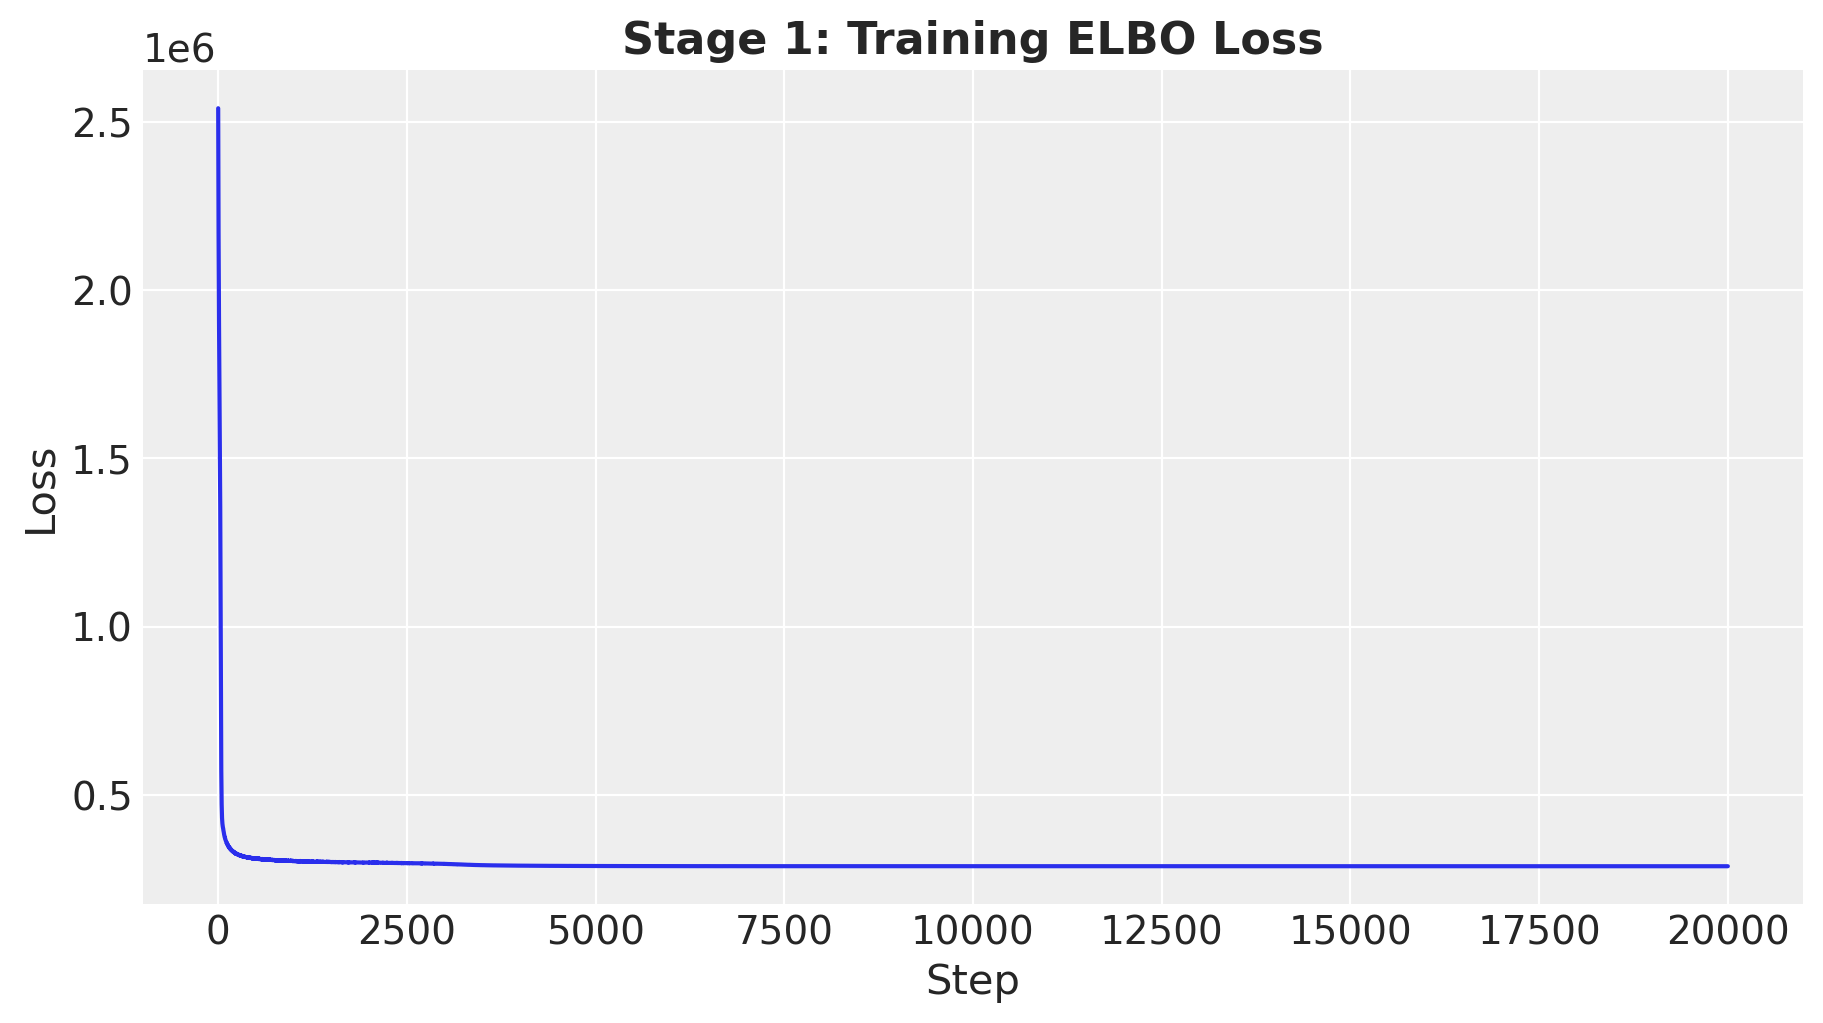

In [ ]:
%%time

num_steps = 20_000

# One-cycle learning rate schedule for stable training
scheduler = optax.linear_onecycle_schedule(
    transition_steps=num_steps,
    peak_value=0.001,
    pct_start=0.3,
    pct_final=0.85,
    div_factor=2,
    final_div_factor=5,
)

optimizer = optax.adam(learning_rate=scheduler)
svi = SVI(conditioned_model, guide, optimizer, loss=Trace_ELBO())

rng_key, rng_subkey = random.split(rng_key)
svi_result = svi.run(
    rng_subkey, num_steps, x=x_train, t=t_train, y=y_train, latent_dim=LATENT_DIM
)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(svi_result.losses)
ax.set_title("Stage 1: Training ELBO Loss", fontsize=16, fontweight="bold")
ax.set_xlabel("Step")
ax.set_ylabel("Loss")

## Stage 2: Test-Time Encoder Training

This is a **critical step** that is often overlooked. At test time, we need to
infer $z$ from $x$ alone (not $t$ and $y$) because:

1. **For CATE estimation**: We want to predict outcomes under **both** treatments,
   so we cannot condition on the observed treatment
2. **For counterfactual reasoning**: We need the same $z$ for both potential
   outcomes

We train a new encoder $q(z \mid x)$ while **keeping the decoder networks fixed**.
This ensures the test encoder learns to produce $z$ values that are consistent
with the learned generative model.

100%|██████████| 5000/5000 [00:11<00:00, 449.60it/s, init loss: 123599.4531, avg. loss [4751-5000]: 57710.7031]


CPU times: user 24.4 s, sys: 5.14 s, total: 29.5 s
Wall time: 11.3 s


Text(0, 0.5, 'Loss')

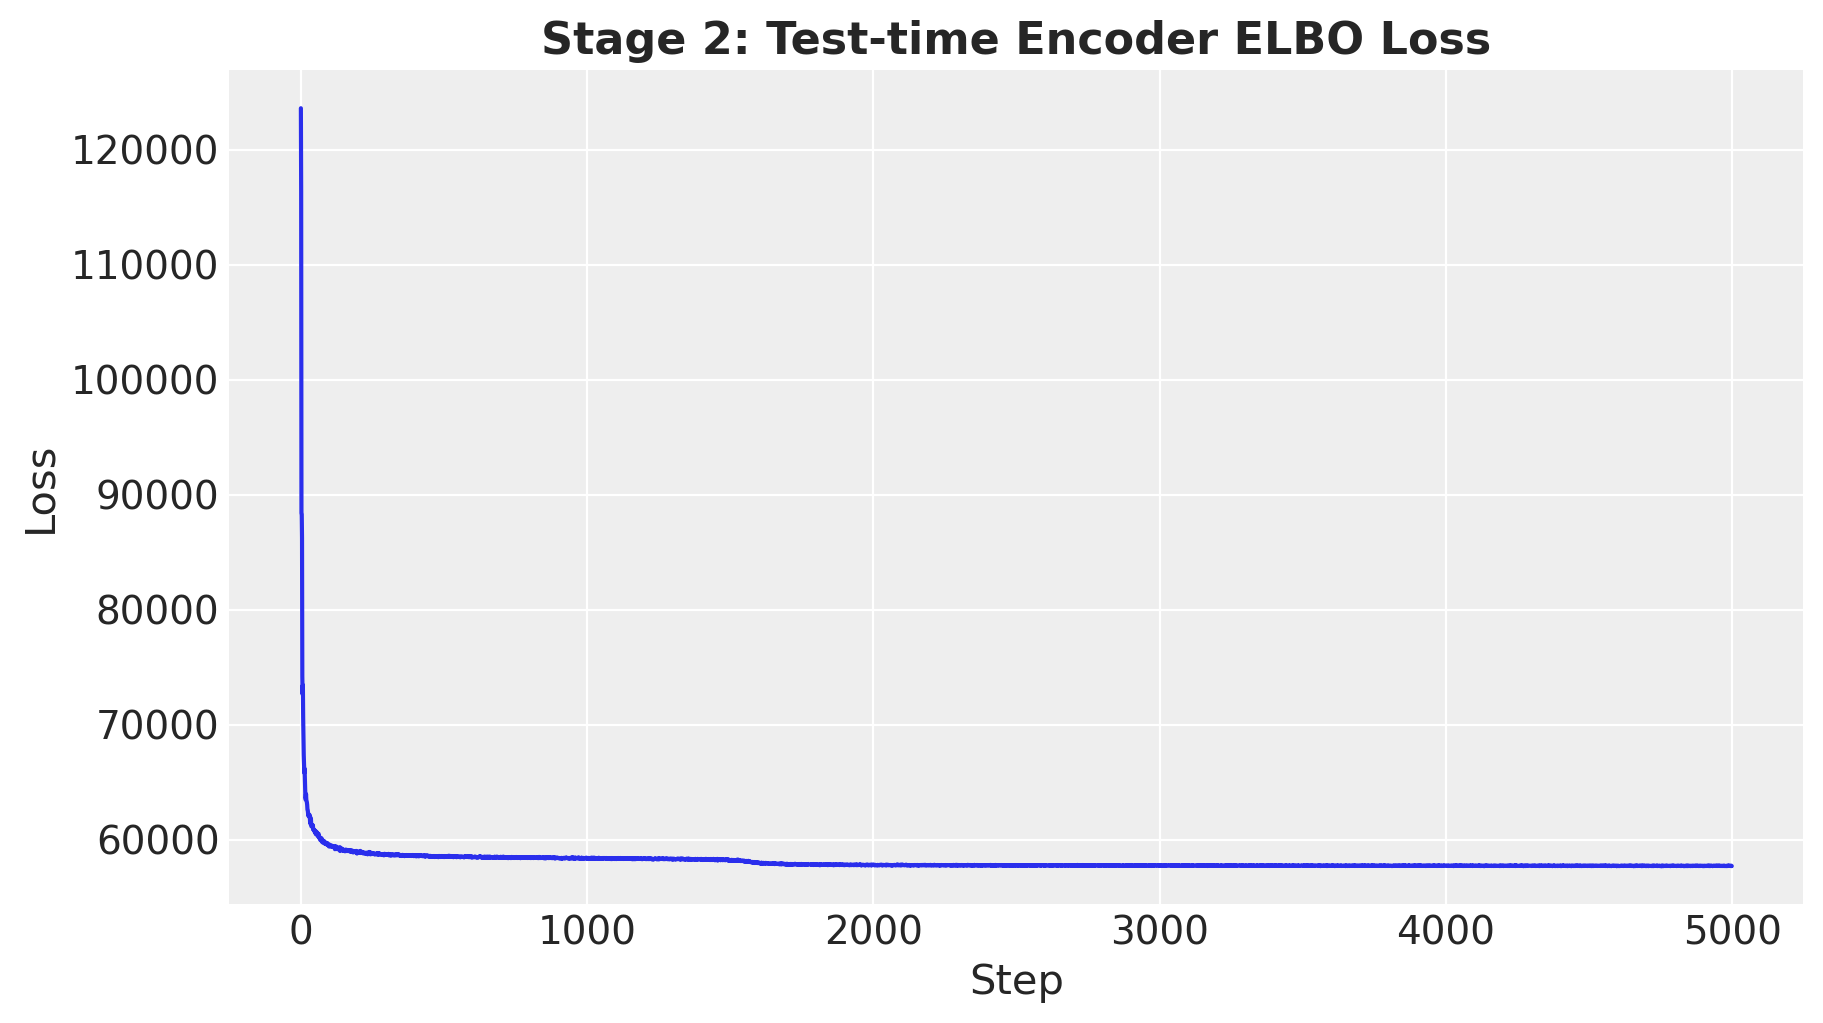

In [ ]:
%%time

params = svi_result.params

# Condition on test data for the second stage
test_conditioned_model = condition(
    model, data={"x_obs": x_test, "t_obs": t_test, "y_obs": y_test}
)

test_num_steps = 5_000
test_scheduler = optax.linear_onecycle_schedule(
    transition_steps=test_num_steps,
    peak_value=0.001,
    pct_start=0.3,
    pct_final=0.85,
    div_factor=2,
    final_div_factor=5,
)
test_optimizer = optax.adam(learning_rate=test_scheduler)
test_svi = SVI(test_conditioned_model, test_guide, test_optimizer, loss=Trace_ELBO())

rng_key, rng_subkey = random.split(rng_key)
test_svi_result = test_svi.run(
    rng_subkey,
    test_num_steps,
    x=x_test,
    t=t_test,
    y=y_test,
    latent_dim=LATENT_DIM,
    # Initialize with trained parameters (keeps decoders fixed)
    init_params=params.copy(),
)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(test_svi_result.losses)
ax.set_title("Stage 2: Test-time Encoder ELBO Loss", fontsize=16, fontweight="bold")
ax.set_xlabel("Step")
ax.set_ylabel("Loss")

## CATE Estimation: The Correct Approach

Now we can estimate CATE using the trained model. The key insight is that we must
use the **same** $z$ samples when computing both potential outcomes.

### The Algorithm

1. **Sample $z$ from the test-time guide**: $z \sim q(z \mid x)$
   - This infers the latent confounder from covariates only

2. **Compute $Y(0)$**: Use `condition(model, {"z": z_sample})` + `do({"t_obs": 0})`
   - Fix $z$ to the sampled value
   - Intervene to set treatment to 0

3. **Compute $Y(1)$**: Use `condition(model, {"z": z_sample})` + `do({"t_obs": 1})`
   - Use the **same** $z$ sample
   - Intervene to set treatment to 1

4. **CATE**: $\widehat{\text{CATE}} = Y(1) - Y(0)$

### NumPyro Handlers

We use two NumPyro handlers:
- `condition`: Fixes a random variable to a specific value (for $z$)
- `do`: Implements a causal intervention (for $t$)

The combination `do(condition(model, {"z": z}), {"t_obs": t})` gives us the
interventional distribution $p(y \mid \text{do}(T=t), z)$.

In [ ]:
test_params = test_svi_result.params
num_samples = 2_000

# Step 1: Sample z from the test-time guide (infers z from x only)
z_predictive = Predictive(
    model=model,
    guide=test_guide,
    params=test_params,
    num_samples=num_samples,
    return_sites=["z"],
)

rng_key, rng_subkey = random.split(rng_key)
z_samples = z_predictive(
    rng_subkey, x=x_test, t=t_test, y=y_test, latent_dim=LATENT_DIM
)["z"]  # Shape: (num_samples, num_data, latent_dim)


# Step 2: Compute potential outcomes using the SAME z samples
def compute_y_obs_under_intervention(z_sample, t_value, params, rng_key):
    """Compute y_obs under do(t_obs=t_value) with fixed z.

    This is the correct way to compute counterfactuals:
    1. condition on z to fix the latent confounder
    2. do() to intervene on treatment
    3. Sample from the resulting distribution
    """
    # Intervene on t_obs AND condition on z
    intervened_model = do(
        condition(model, data={"z": z_sample}),
        data={"t_obs": jnp.full(NUM_TEST, t_value)},
    )

    predictive = Predictive(
        model=intervened_model,
        params=params,
        num_samples=1,
        return_sites=["y_obs"],
    )

    return predictive(rng_key, x=x_test, t=t_test, y=y_test, latent_dim=LATENT_DIM)[
        "y_obs"
    ].squeeze(0)


# Compute y_obs under both interventions for each z sample
rng_key, rng_subkey = random.split(rng_key)
rng_keys = random.split(rng_subkey, num_samples * 2)

# Y(0): Outcome under control (t=0)
y_obs_t0_samples = jax.vmap(
    lambda z, key: compute_y_obs_under_intervention(z, 0, test_params, key)
)(z_samples, rng_keys[:num_samples])

# Y(1): Outcome under treatment (t=1)
y_obs_t1_samples = jax.vmap(
    lambda z, key: compute_y_obs_under_intervention(z, 1, test_params, key)
)(z_samples, rng_keys[num_samples:])

# CATE = E[Y(1) - Y(0) | z]
# Since y_obs is binary, the mean across samples gives P(Y=1|do(T), z)
cate_samples = y_obs_t1_samples - y_obs_t0_samples  # Shape: (num_samples, num_data)
est_cates = np.asarray(cate_samples.mean(axis=0))

## Results

Let's compare our CATE estimates to the true values from the DGP.

/var/folders/wj/wjy2vm8d7_j9v43bv29zcgl80000gq/T/ipykernel_91184/2416596337.py:49: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


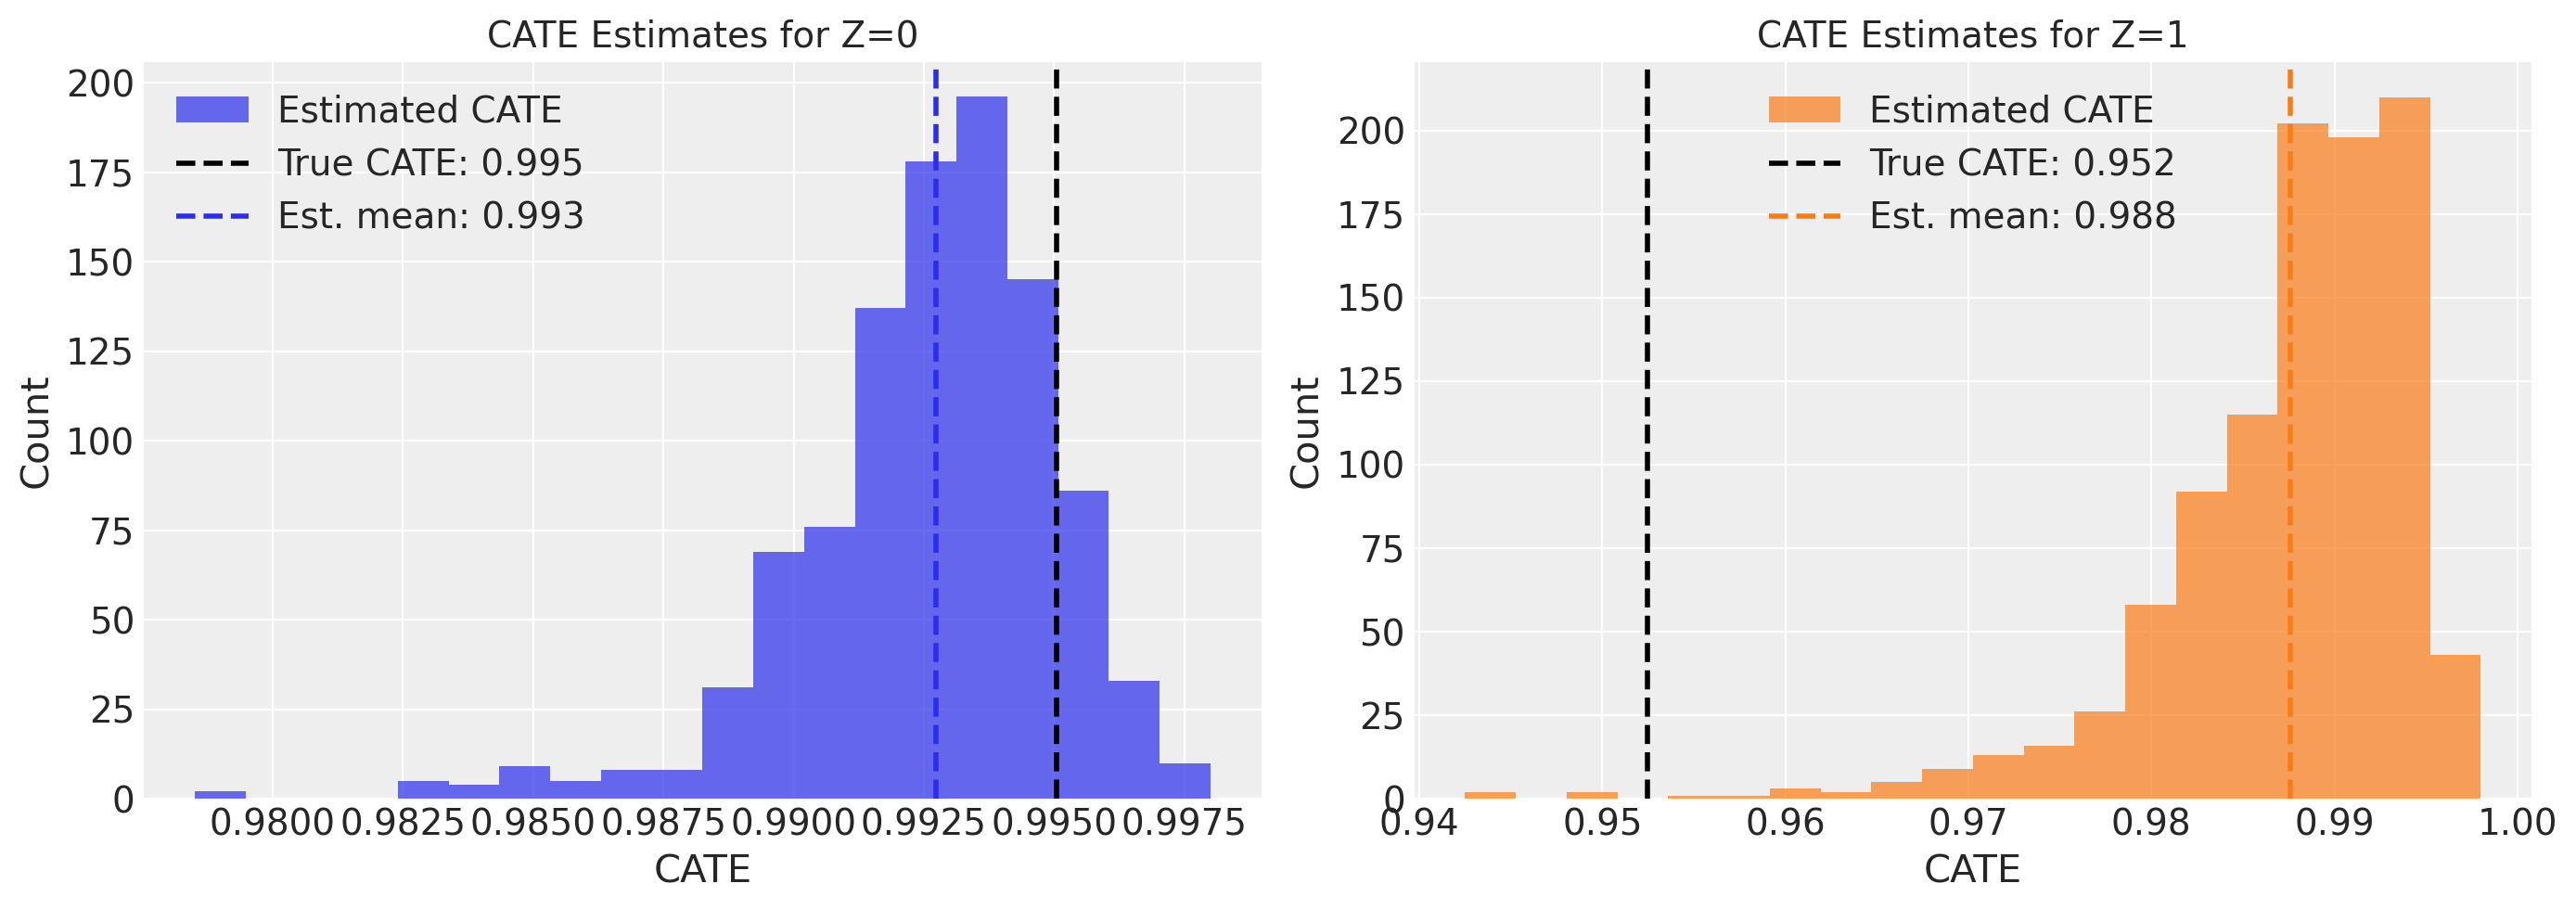

In [ ]:
# Separate estimates by true z value (for evaluation)
est_cates_z0 = est_cates[z_test == 0]
est_cates_z1 = est_cates[z_test == 1]
true_cate_z0 = true_cate_probs[z_test == 0]
true_cate_z1 = true_cate_probs[z_test == 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(est_cates_z0, bins=20, color="C0", alpha=0.7, label="Estimated CATE")
axes[0].axvline(
    true_cate_z0.mean().item(),
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"True CATE: {true_cate_z0.mean().item():.3f}",
)
axes[0].axvline(
    est_cates_z0.mean(),
    color="C0",
    linestyle="--",
    linewidth=2,
    label=f"Est. mean: {est_cates_z0.mean():.3f}",
)
axes[0].set_title("CATE Estimates for Z=0", fontsize=14)
axes[0].set_xlabel("CATE")
axes[0].set_ylabel("Count")
axes[0].legend()

axes[1].hist(est_cates_z1, bins=20, color="C1", alpha=0.7, label="Estimated CATE")
axes[1].axvline(
    true_cate_z1.mean().item(),
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"True CATE: {true_cate_z1.mean().item():.3f}",
)
axes[1].axvline(
    est_cates_z1.mean(),
    color="C1",
    linestyle="--",
    linewidth=2,
    label=f"Est. mean: {est_cates_z1.mean():.3f}",
)
axes[1].set_title("CATE Estimates for Z=1", fontsize=14)
axes[1].set_xlabel("CATE")
axes[1].set_ylabel("Count")
axes[1].legend()

plt.tight_layout()

In [ ]:
print("=" * 60)
print("CATE Estimation Results")
print("=" * 60)
print(
    f"Z=0: True CATE = {true_cate_z0.mean().item():.3f}, "
    f"Est. CATE = {est_cates_z0.mean():.3f}"
)
print(
    f"Z=1: True CATE = {true_cate_z1.mean().item():.3f}, "
    f"Est. CATE = {est_cates_z1.mean():.3f}"
)
print("=" * 60)

CATE Estimation Results
Z=0: True CATE = 0.995, Est. CATE = 0.993
Z=1: True CATE = 0.952, Est. CATE = 0.988


## Summary and Key Takeaways

### What We Learned

1. **CEVAE can recover CATE** even with unobserved confounders, by inferring
   the latent confounder from observed proxies (covariates)

2. **Architecture matters**: Using separate linear networks for each treatment
   level prevents the model from ignoring the latent variable

3. **Two-stage inference**: Train the main model first, then train a test-time
   encoder that infers $z$ from $x$ alone

4. **Correct counterfactual computation**: Use `condition` + `do` to ensure the
   same $z$ is used for both potential outcomes

### Common Pitfalls to Avoid

| Pitfall | Why It Fails | Solution |
|---------|--------------|----------|
| Naive ATE | Confounding bias | Use causal model |
| Separate `do()` calls | Different $z$ samples | `condition(z)` + `do(t)` |
| Single outcome network | Ignores $z$, relies on $t$ | Separate networks per $t$ |
| Using $(x,t,y)$ at test time | Can't compute counterfactuals | Train $q(z \mid x)$ |

### References

- [Louizos et al. (2017) - Causal Effect Inference with Deep Latent-Variable
  Models](https://arxiv.org/abs/1705.08821)
- [ChiRho CEVAE Tutorial](https://basisresearch.github.io/chirho/cevae.html)
- [NumPyro Documentation](https://num.pyro.ai/)